Workflow to fit SVM per day of recording on selected gestrues (identified from Day 16/day 1).

In [38]:
import os
import sys
notebook_dir = os.getcwd()
project_dir = os.path.dirname(notebook_dir)
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)

from srcs.engdataset import ENGDataset, Nerve
import utils.preprocessing as pre
import utils.classify as classify
import utils.plot as uplot
from constants import *

from collections import Counter
import logging
from collections import namedtuple
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from typing import Dict, List


plt.rcParams.update({"figure.dpi": 150})
plt.rcParams['axes.axisbelow'] = True
logging.getLogger().setLevel(logging.INFO)
matplotlib.rcParams.update({'font.size': 6})

plt.rcParams.update({
            "figure.dpi": 150, 'font.size': 10,
            'figure.figsize': (5,3), 'axes.axisbelow': True,
            'axes.edgecolor': COLOR_DICT['clouds'], 'axes.linewidth': 0.4
        })

logging.getLogger().setLevel(logging.INFO)
%matplotlib inline 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Load ENG Data

In [53]:
# load raw ENG for the following parameters
day = 16                   # day of recording: can be 16, 17 or 23
session = '01'             # session of recording

preproc_plots = False      # whether to plot figures during preprocessing
filter_signal = False      # whether to filter all channels or reload a saved file with filtered data
save_figs = True
optimize_mem = True        # whether to save some memory by deleting raw df once not needed.

feature = 'power'
wind_size = 0.2          # window size in seconds
overlap_perc = 0.5          # overlap ratio
organize_strat = 'flx_vs_ext_separate'     #  defines how to prepare the dataset: 'flx_vs_ext_separate' or 'flx_vs_ext_together' or'flx_vs_ext_combined'

# Select only few classes from all for classification
Gest_namedtup = namedtuple('gesture', ['id', 'phase'])
sel_gest_phase = [Gest_namedtup(0, 'Open'),
                  Gest_namedtup(1, 'Close'),
                  # Gest_namedtup(2,'Close'),
                  Gest_namedtup(3, 'Close'),
                  Gest_namedtup(4, 'Close')]


# Classifier parameters
seed = 10     # random seed used for splitting the k-folds
k_cv = 5     # number of k folds

In [3]:
# create directory for figures
directories = [FIG_DIR, CLF_FIG, FILTERED_DIR, CLF_RESULTS_DIR]

for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)

CLF_FIG = os.path.join(FIG_DIR, 'clf')
if not os.path.exists(CLF_FIG):
    os.makedirs(CLF_FIG)

In [4]:
eng_dataset = ENGDataset(day= day, session=session, load_raw_data = True, save_figs=save_figs)
pipeline = {'bp_order': 3, 'bp_cutoff_freq': np.array([300, 2000]), 'notch_bandwidth': 0.5, 'notch_reject': 50}
eng_dataset.filt_pipeline = pipeline

INFO:root:Loading data from /Users/farahbaracat/Library/CloudStorage/OneDrive-UniversitätZürichUZH/ENG upper dataset/Data_TIME_Marina/day16/AM_prese_1601_raw_ENG.mat
INFO:root:Loading data from /Users/farahbaracat/Library/CloudStorage/OneDrive-UniversitätZürichUZH/ENG upper dataset/Data_TIME_Marina/day16/AM_prese_1601_raw_ENG_ok.mat
INFO:root:Creating dictionary of reps count per task: {0: 10, 1: 10, 2: 10, 3: 7, 4: 10}
INFO:root:Time column of post_data(7157879,) 
Rec column of post_data(56, 7157879)


In [5]:
def show_matfile_vars(data):
    for key in data.keys():
        if isinstance(data[key], np.ndarray):
            print(f"{key}: {data[key].dtype} {data[key].shape} ")
        if isinstance(data[key], list):
            print(f"{key}: list {len(data[key])}")
    print("\n")
show_matfile_vars(eng_dataset.raw_data)
show_matfile_vars(eng_dataset.post_data)

REC: float64 (56, 7607880) 
Time: float64 (7607880,) 
Trigger: float64 (49,) 


REC: float64 (56, 7157879) 
SEGM_tot: list 5
Trigger: float64 (47,) 
Time: float64 (7157879,) 




# 2.Filter the raw data

In [6]:
if filter_signal: # filter all channels and plot the bandpassed version
    notch_filt_data, bp_filt_data = pre.apply_filter_pipeline(eng_dataset)

    if preproc_plots:
    # plot single ch fft after filtering
        fig = plt.figure(figsize=(8, 4))
        gs = gridspec.GridSpec(nrows=3, ncols=1)
        sel_ch = 0
        xlim = [0,  pipeline['bp_cutoff_freq'][-1]]  # in Hz

        xf_raw, yf_raw = pre.get_fft(np.array(eng_dataset.post_data_df[sel_ch]), ENG_FS)

        xf_bp, yf_bp = pre.get_fft(bp_filt_data[:, sel_ch], ENG_FS)
        xf_not, yf_not = pre.get_fft(notch_filt_data[:, sel_ch], ENG_FS)

        ax = fig.add_subplot(gs[0])
        ax.plot(xf_raw, np.sqrt(np.abs(yf_raw)), label='raw', color=COLOR_DICT['midnight_blue'])
        ax.set(frame_on=False)
        plt.xlim(xlim)
        plt.ylabel('amplitude [uV]')
        plt.title(f"Signal ch:{sel_ch} after Notch filters + BP: {pipeline['bp_cutoff_freq']}", fontsize=8)

        ax2 = fig.add_subplot(gs[1])
        ax2.plot(xf_not, np.sqrt(np.abs(yf_not)), label='Notch', color=COLOR_DICT['pumpkin'])
        ax2.set(frame_on=False)
        plt.legend()
        plt.xlim(xlim)

        # plt.xticks(ticks=np.arange(-0,1000,50))
        plt.ylabel('amplitude [uV]')

        ax1 = fig.add_subplot(gs[2])
        ax1.plot(xf_bp, np.sqrt(np.abs(yf_bp)), label='BPF', color=COLOR_DICT['midnight_blue'])
        ax1.set(frame_on=False)
        plt.legend()
        plt.xlim(xlim)
        plt.ylabel('amplitude [uV]')
        plt.xlabel('freq [Hz]')
        plt.show()

        fig.savefig(f"figures/fft_bp_{pipeline['bp_cutoff_freq'][0]}_"
                    f"{pipeline['bp_cutoff_freq'][1]}.png")

In [7]:
# save filtered data to pickle or load from pickle a presaved filtered data
filt_filename = f"day{eng_dataset.day}{eng_dataset.session}_eng_filt_{eng_dataset.filt_pipeline['bp_cutoff_freq'][0]}_{eng_dataset.filt_pipeline['bp_cutoff_freq'][1]}.pkl"
if filter_signal:
    # organize filtered data in dataframe
    filt_df = pd.DataFrame(bp_filt_data)
    filt_df[TIME_VAR] = eng_dataset.post_data_df[TIME_VAR]
    filt_df.to_pickle(os.path.join(FILTERED_DIR, filt_filename))
else:
    logging.info(f"Loading filtered data from {filt_filename}")
    filt_df = pd.read_pickle(os.path.join(FILTERED_DIR, filt_filename))
eng_dataset.filt_df = filt_df


INFO:root:Loading filtered data from day1601_eng_filt_300_2000.pkl


In [8]:
bad_channels, bad_channels_std = pre.detect_bad_channels(eng_dataset, std_threshold=6)
print(f"Bad channels:{bad_channels}\nBad channels std:{np.round(bad_channels_std,3)}")

INFO:root:Nerve.MEDIAN_E1: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Channels median of stds: 0.9994738317477818

INFO:root:Nerve.MEDIAN_E2: [14 15 16 17 18 19 20 21 22 23 24 25 26 27]
Channels median of stds: 1.5129269970719061

INFO:root:Nerve.ULNAR_E1: [28 29 30 31 32 33 34 35 36 37 38 39 40 41]
Channels median of stds: 1.2218176684677338

INFO:root:Nerve.ULNAR_E2: [42 43 44 45 46 47 48 49 50 51 52 53 54 55]
Channels median of stds: 1.3015219241400366



Bad channels:[1, 2, 5, 7]
Bad channels std:[8.39  6.585 6.036 6.101]


In [9]:
# # plot bad channels
# fig = plt.figure(figsize=(8, 4))
# gs = gridspec.GridSpec(nrows=4, ncols=2)
# bad_channels_good = bad_channels + [43,0]
# for i, ch in enumerate(bad_channels_good):
#     ax = fig.add_subplot(gs[i])
#     ax.plot(eng_dataset.filt_df[TIME_VAR], eng_dataset.filt_df[ch], label='raw', color=COLOR_DICT['midnight_blue'])
#     plt.ylabel('amplitude [uV]')
#     plt.title(f"Bad channel {ch}")
#     # ax.set_xlim([5.645, 5.8])
#     # ax.set_ylim([-800,800])

# fig.tight_layout()


# 3. Unfold each rep in time and fit SVM

In [10]:
# optimizing some memory
if optimize_mem:
    eng_dataset._detete_raw_data()

In [58]:
bad_channels, wind_size

([1, 2, 5, 7], 0.15)

INFO:root:clf_df['label'].unique():[1 2 6 8]



Average number of windows per class
class_label
0     12.0
1     12.0
2     12.0
3     12.0
4     12.0
5     12.0
6     12.0
7     12.0
8     12.0
9     12.0
10    56.4
dtype: float64

Gesture id:0  task:Tripod  phase:Open
Gesture id:1  task:ThOpp.  phase:Close
Gesture id:3  task:UlnarFing.  phase:Close
Gesture id:4  task:FingAbd.  phase:Close
Selected classes:[1, 2, 6, 8] with names:
['Tripod Open', 'ThOpp. Close', 'UlnarFing. Close', 'FingAbd.']


INFO:root:Fold 0
-------------
Train sample ids:[ 0  1  2  3  4  7  8  9 10 11 12 13 14 15 16 17 21 22 23 25 26 28 29 30
 31 32 33 34 35]
Test sample ids:[ 5  6 18 19 20 24 27 36]
Counter train:Counter({1: 96, 2: 96, 8: 96, 6: 60})
Counter test: Counter({1: 24, 2: 24, 6: 24, 8: 24}) 
pred_labels: [1 2 6 8]
INFO:root:Train: (348, 56) , (348,) Test: (96, 56) , (96,)
-------------------

INFO:root:Fold 1
-------------
Train sample ids:[ 0  2  3  5  6  7  8  9 10 12 13 14 15 16 18 19 20 21 23 24 26 27 28 29
 32 33 34 35 36]
Test sample ids:[ 1  4 11 17 22 25 30 31]
Counter train:Counter({1: 96, 2: 96, 8: 96, 6: 60})
Counter test: Counter({1: 24, 2: 24, 6: 24, 8: 24}) 
pred_labels: [1 2 6 8]
INFO:root:Train: (348, 56) , (348,) Test: (96, 56) , (96,)
-------------------

INFO:root:Fold 2
-------------
Train sample ids:[ 0  1  3  4  5  6  7  9 11 13 14 15 16 17 18 19 20 21 22 23 24 25 27 28
 30 31 32 33 35 36]
Test sample ids:[ 2  8 10 12 26 29 34]
Counter train:Counter({1: 96, 2: 96, 8: 96, 



 recall class fold:[[0.66666667 0.58333333 0.5        1.        ]
 [0.79166667 0.79166667 0.54166667 0.91666667]
 [0.70833333 0.54166667 0.08333333 0.91666667]
 [0.79166667 0.83333333 0.58333333 0.29166667]
 [0.625      0.70833333 0.16666667 0.79166667]]
Mean prec:[0.76202359 0.77184211 0.45929038 0.68959943]  std prec:[0.1020982  0.13606459 0.27628954 0.17062562]  Mean recall:[0.71666667 0.69166667 0.375      0.78333333]  std recall:[0.06666667 0.11365151 0.20749833 0.25467845]
std recall:[0.06666667 0.11365151 0.20749833 0.25467845]


INFO:root:Saved fig in figures/day1601/clf/seed_10_power_kcv_5_nchs_56_conf_matrix_linear_['Tripod Open', 'ThOpp. Close', 'UlnarFing. Close', 'FingAbd.']_temporal_True_bin_0.15.png
INFO:root:Results_df as a fig is saved to figures/day1601/clf/seed_10_power_kcv_5_nchs_56_acc_df_linear_['Tripod Open', 'ThOpp. Close', 'UlnarFing. Close', 'FingAbd.']_temporal_True_bin_0.15.png


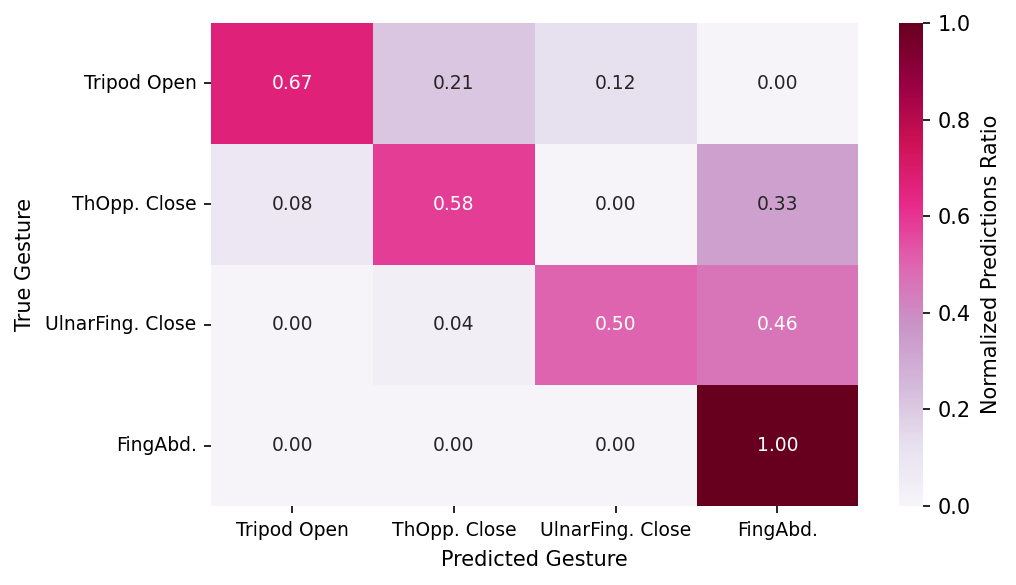

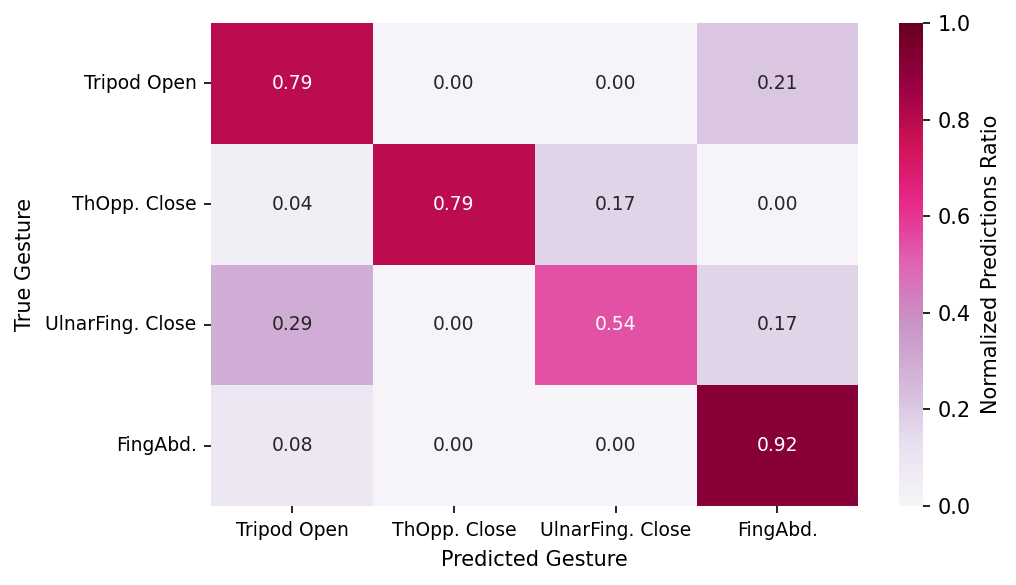

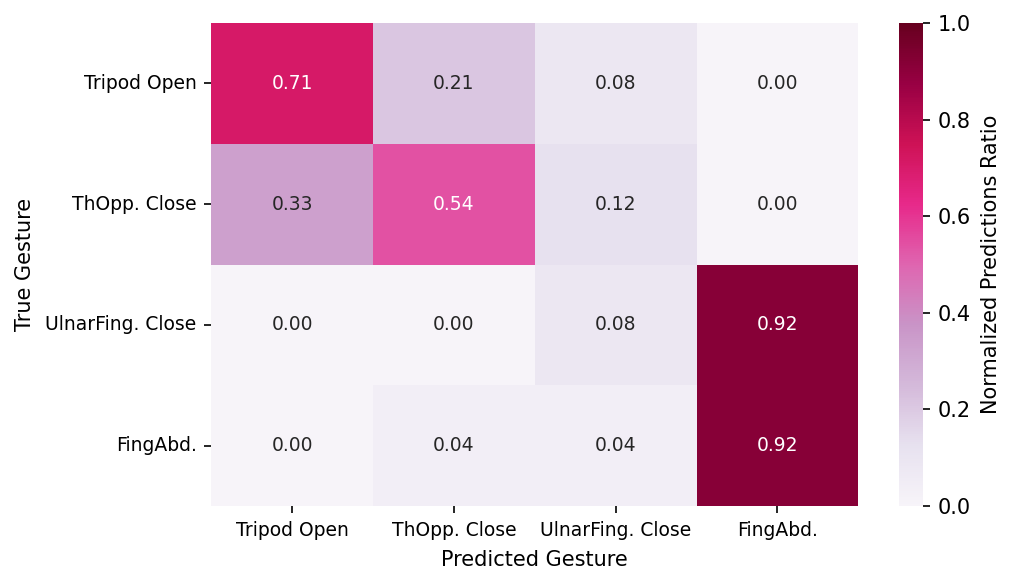

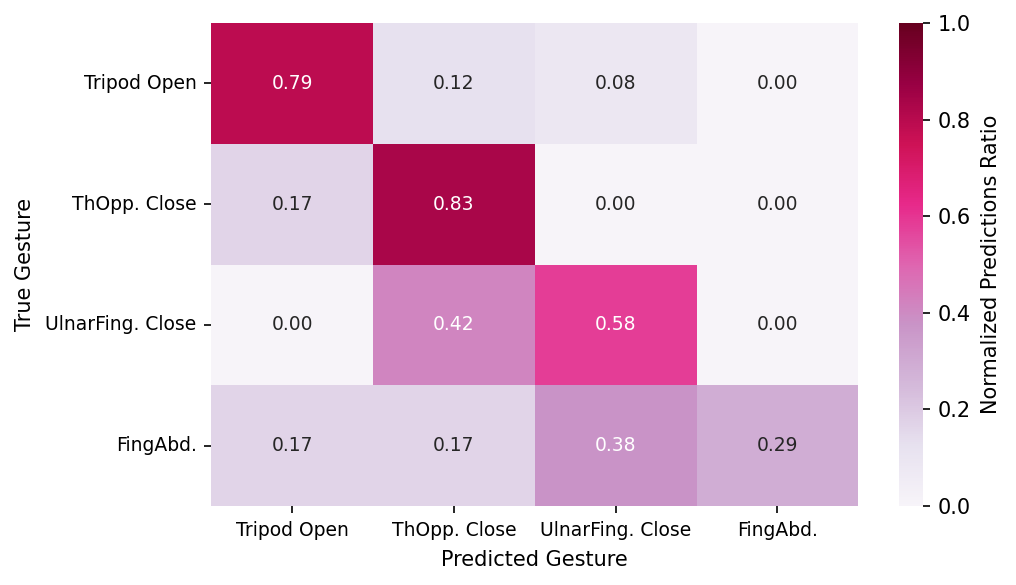

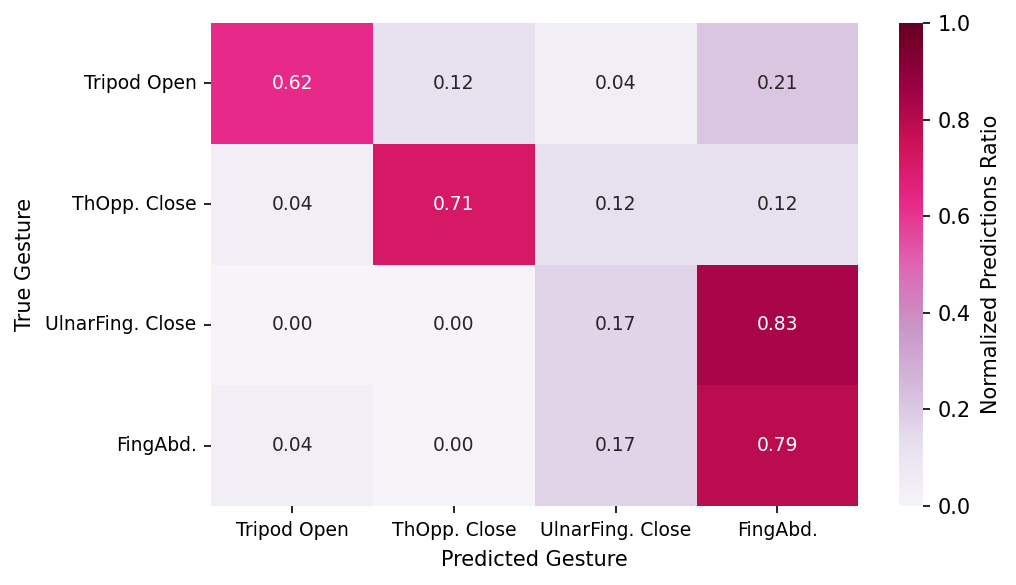

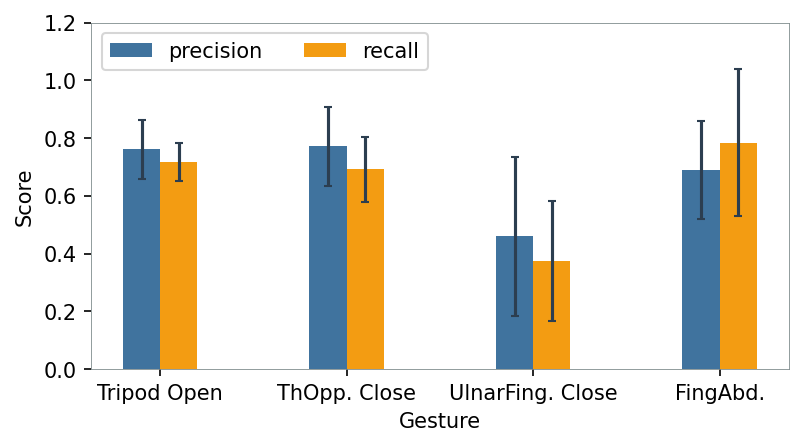

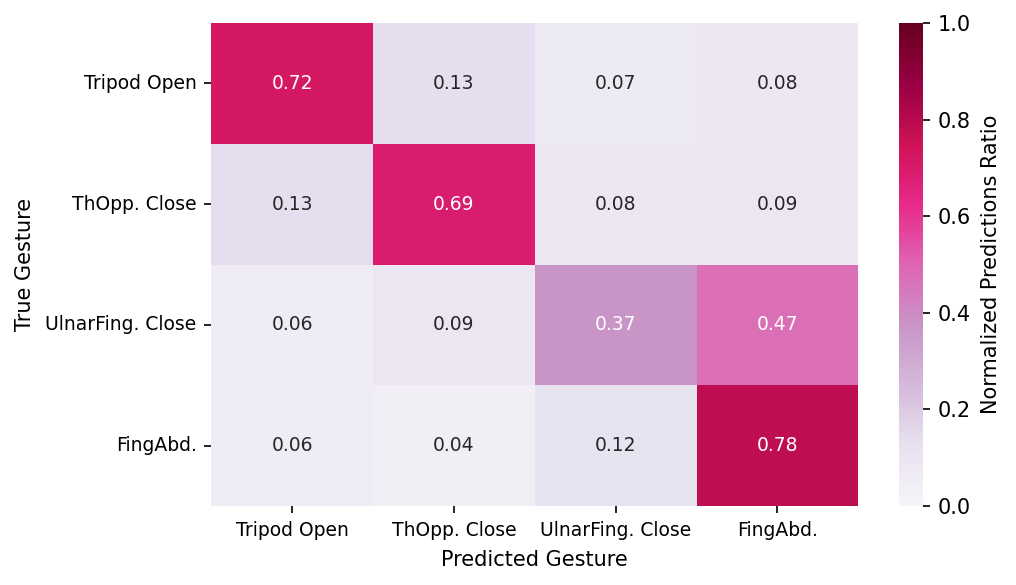

In [54]:
input_df, labels_map = classify.prepare_input_df(eng_dataset, feature, organize_strat,  wind_size, overlap_perc)
avg_win_per_class = input_df.groupby([LABEL_COL],as_index=True)[FEAT_WIN_COL].count() / input_df.groupby([LABEL_COL],as_index=True)[REP_ID_COL].nunique()
print(f"Average number of windows per class\n{avg_win_per_class}\n")


select_class, select_class_labels = pre.encode_gest_phase(eng_dataset, sel_gest_phase, labels_map)
print(f"Selected classes:{select_class} with names:\n{select_class_labels}")
results_df = classify.fit_svm(input_df, labels_map, select_class, eng_dataset,
                              annotate_cm=False,
                              seed=seed,
                              is_temporal=True,
                              k_cv=k_cv,
                              bad_channels=[], # old code, [1,2,43] for day 16, session 01
                              bin_width=wind_size,
                              bin_stat=feature,
                              exp_var=None)

In [55]:
results_df

,acc_train,acc_val,f1_train,f1_val,prec_train,prec_val,recall_train,recall_val
0,0.926042,0.687500,0.933460,0.682518,0.933726,0.736757,0.933908,0.687500
1,0.936458,0.760417,0.936958,0.758712,0.937566,0.782389,0.936782,0.760417
2,0.936632,0.562500,0.938830,0.606597,0.939773,0.600659,0.938889,0.630952
3,0.960069,0.625000,0.961299,0.612666,0.961713,0.720899,0.961111,0.630952
4,0.929688,0.572917,0.930669,0.633798,0.932113,0.670248,0.930556,0.630952


In [56]:
results_df.mean()

acc_train       0.937778
acc_val         0.641667
f1_train        0.940243
f1_val          0.658858
prec_train      0.940978
prec_val        0.702190
recall_train    0.940249
recall_val      0.668155
dtype: float64

In [57]:
print(fr"Mean balanced acc across all classes:{np.round(results_df['acc_val'].mean(),4)*100} % +- {np.round(results_df['acc_val'].std(),4)*100} %")

Mean balanced acc across all classes:64.17 % +- 8.290000000000001 %
